
# Laboratorio 7 — Predicción de Diabetes con AutoGluon
**Curso:** CC3084 – Data Science (Semestre II – 2025)  
**Autores:** Gabriel Paz - Carlos Valladares  
**Fecha de ejecución del cuaderno:** 2025-09-29 05:34

Este cuaderno implementa **todo el flujo** solicitado en el laboratorio y sigue la **rúbrica para 100 puntos**:
- Carga y preparación de datos
- EDA (distribuciones, nulos/atípicos, balance de clases, correlaciones)
- Entrenamiento con **AutoGluon** usando `preset="best_quality"` y métrica `accuracy`, con límite de tiempo
- Comparación con un **modelo base** (Regresión Logística)
- Evaluación (leaderboard, matriz de confusión, métricas adicionales, ROC/AUC)
- Importancia de características
- **Reflexión crítica** sobre AutoML/AutoGluon en salud

> **Nota:** Por conveniencia, el cuaderno asume que el archivo `diabetes.csv` está en la misma carpeta del cuaderno. Si ejecuta en Google Colab, suba el archivo o monte su Google Drive.



## 1. Instalación de dependencias y configuración


In [2]:


import warnings, os, sys, math, itertools, time, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, classification_report, roc_curve, auc,
                             accuracy_score, precision_score, recall_score, f1_score)

# Configuración general
pd.set_option("display.max_columns", 100)
sns.set(style="whitegrid", context="notebook")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)



## 2. Carga del conjunto de datos y descripción de variables
La columna objetivo es **`Outcome`** (1 = tiene diabetes, 0 = no tiene). A continuación se cargan los datos.


In [3]:

# Ruta al CSV (asuma que está en la misma carpeta del cuaderno)
DATA_PATH = "diabetes.csv"

# Carga
df = pd.read_csv(DATA_PATH)

print("Dimensiones:", df.shape)
display(df.head())
display(df.tail())
print("\nInformación del DataFrame:")
display(df.info())


Dimensiones: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1
767,1,93,70,31,0,30.4,0.315,23,0



Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


None


**Glosario de variables** (resumen):
- `Pregnancies`: Número de veces que ha estado embarazada.
- `GlucosePlasma`: Concentración de glucosa en plasma.
- `BloodPressure`: Presión sanguínea diastólica (mm Hg).
- `Skin`: Grosor del pliegue cutáneo del tríceps (mm).
- `Insulin`: Insulina sérica a las 2 horas (mu U/ml).
- `BMI`: Índice de masa corporal (peso en kg / (estatura en m)^2).
- `DiabetesPedigreeFunction`: Función de pedigree de diabetes.
- `Age`: Edad en años.
- `Outcome`: 1 si el paciente tiene diabetes, 0 si no.



## 3. Análisis Exploratorio de Datos (EDA)
Incluye estadísticas descriptivas, revisión de nulos/atípicos, distribución de `Outcome`, y correlaciones.


In [4]:

# Estadísticas descriptivas
display(df.describe(include="all"))

# Valores nulos
print("\nValores nulos por columna:")
display(df.isna().sum())

# Duplicados
print("\nRegistros duplicados:", df.duplicated().sum())


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000



Valores nulos por columna:


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


Registros duplicados: 0


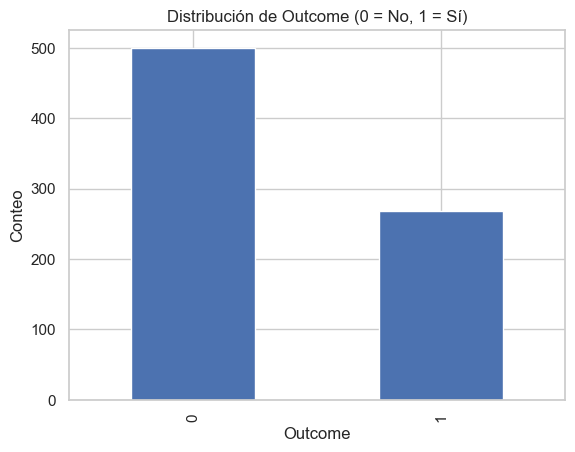

Proporción de clase positiva (1): 0.349


In [5]:

# Distribución de la variable objetivo (balance de clases)
ax = df['Outcome'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribución de Outcome (0 = No, 1 = Sí)')
plt.xlabel('Outcome')
plt.ylabel('Conteo')
plt.show()

print("Proporción de clase positiva (1):", round(df['Outcome'].mean(), 3))


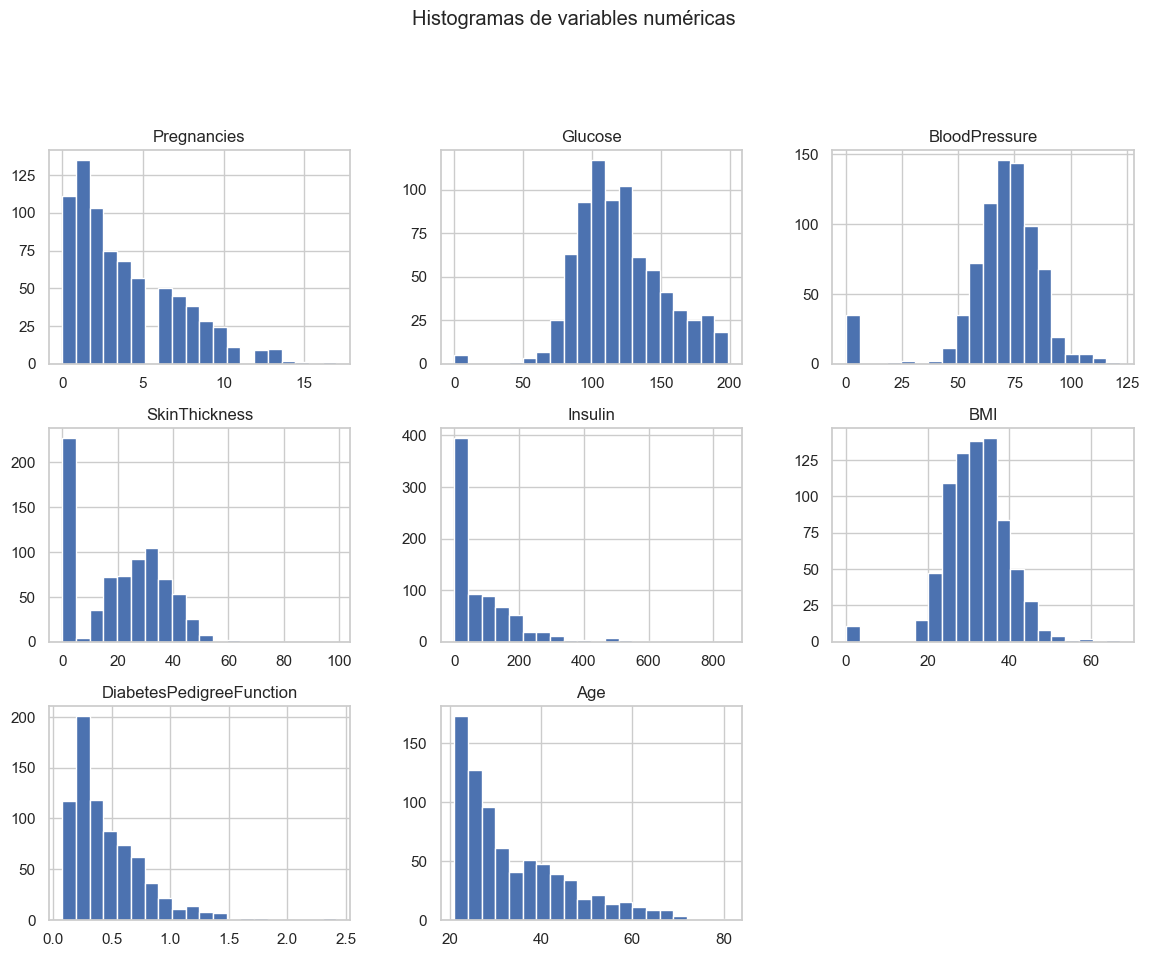

In [6]:

# Histogramas para variables numéricas
num_cols = [c for c in df.columns if c != 'Outcome']
df[num_cols].hist(figsize=(14, 10), bins=20)
plt.suptitle('Histogramas de variables numéricas', y=1.02)
plt.show()


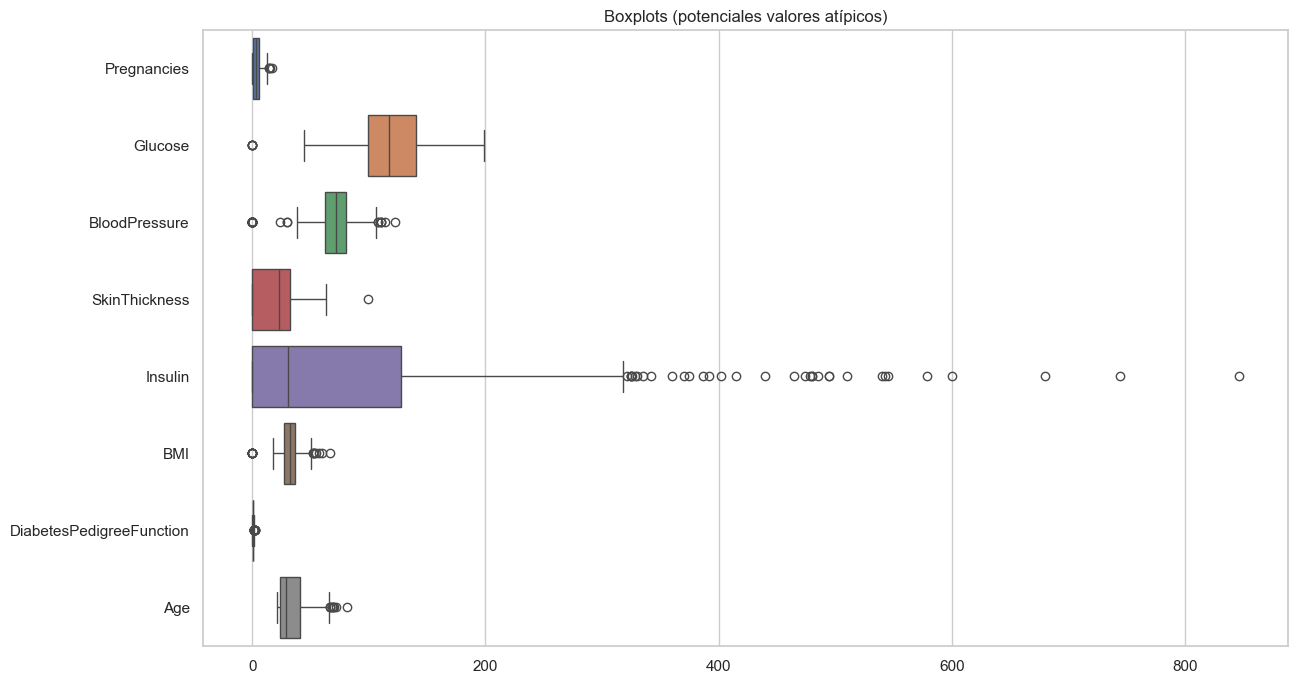

In [7]:

# Boxplots para revisar posibles outliers
plt.figure(figsize=(14, 8))
sns.boxplot(data=df[num_cols], orient='h')
plt.title('Boxplots (potenciales valores atípicos)')
plt.show()


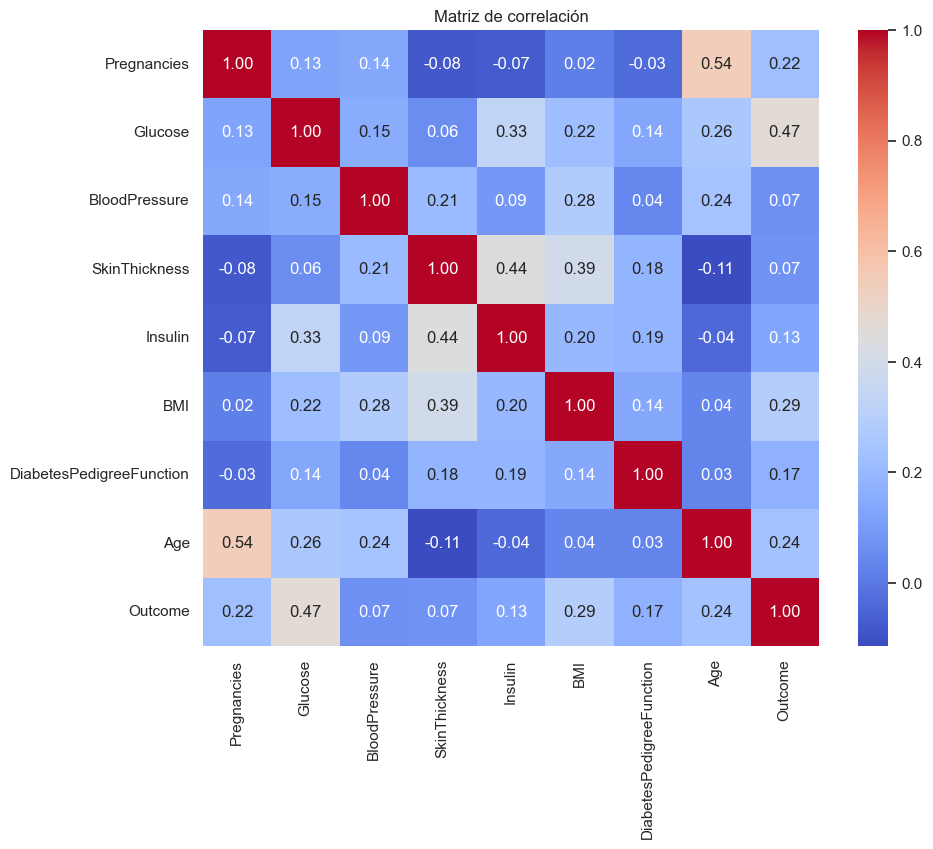


Correlación de cada variable con Outcome (desc):
 Outcome                     1.000000
Glucose                     0.466581
BMI                         0.292695
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
Insulin                     0.130548
SkinThickness               0.074752
BloodPressure               0.065068
Name: Outcome, dtype: float64


In [8]:

# Matriz de correlación y mapa de calor
plt.figure(figsize=(10, 8))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title('Matriz de correlación')
plt.show()

corr_outcome = corr['Outcome'].sort_values(ascending=False)
print("\nCorrelación de cada variable con Outcome (desc):\n", corr_outcome)



### Decisiones sobre nulos/atípicos
En este dataset clásico, ciertos **ceros** en variables fisiológicas (p. ej., `GlucosePlasma`, `BloodPressure`, `Skin`, `Insulin`, `BMI`) se consideran **valores inválidos** y se tratan como faltantes. Se procederá a:
1. Reemplazar ceros por `NaN` en dichas columnas.
2. Imputar con la **mediana** (robusto ante outliers).


In [11]:
from copy import deepcopy
import numpy as np

work_df = deepcopy(df)


print("Columnas disponibles:", list(work_df.columns))

aliases = {
    'GlucosePlasma': ['GlucosePlasma', 'Glucose', 'PlasmaGlucose', 'glucose'],
    'BloodPressure': ['BloodPressure', 'DiastolicBloodPressure', 'Diastolic_BP', 'diastolicbloodpressure'],
    'Skin': ['Skin', 'SkinThickness', 'TricepsSkinThickness', 'SkinFold', 'skin_thickness'],
    'Insulin': ['Insulin', 'TwoHourSerumInsulin', 'Insulin2h', 'Insulin_2h'],
    'BMI': ['BMI', 'BodyMassIndex', 'IMC']
}


label_aliases = ['Outcome', 'Diabetes', 'Class', 'Target']


cols_lower_map = {c.lower(): c for c in work_df.columns}

def resolve_one(candidates):
    for cand in candidates:
        if cand in work_df.columns:
            return cand
        if cand.lower() in cols_lower_map:
            return cols_lower_map[cand.lower()]
    return None

resolved = {}
for key, cands in aliases.items():
    real = resolve_one(cands)
    if real is not None:
        resolved[key] = real
    else:
        print(f"⚠️ No se encontró columna para '{key}'. Se omite en limpieza.")

label_col = resolve_one(label_aliases)
if label_col is None:
    raise KeyError("No se encontró la columna objetivo (busqué: 'Outcome', 'Diabetes', 'Class', 'Target').")

print("Target/label detectado:", label_col)
cols_with_invalid_zero = list(resolved.values())
print("Columnas a limpiar (cero→NaN):", cols_with_invalid_zero)

for c in cols_with_invalid_zero:
    work_df[c] = work_df[c].replace(0, np.nan)

print("Nulos tras reemplazo de ceros inválidos:")
display(work_df[cols_with_invalid_zero].isna().sum())

for c in cols_with_invalid_zero:
    median_val = work_df[c].median()
    work_df[c] = work_df[c].fillna(median_val)

print("Verificación de nulos post-imputación:")
display(work_df.isna().sum())



Columnas disponibles: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
Target/label detectado: Outcome
Columnas a limpiar (cero→NaN): ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
Nulos tras reemplazo de ceros inválidos:


Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64

Verificación de nulos post-imputación:


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


## 4. Partición de datos (Train/Test)
Se hace un **split estratificado** para preservar la proporción de la clase.


In [12]:

X = work_df.drop(columns=['Outcome'])
y = work_df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Tamaños -> X_train:", X_train.shape, "X_test:", X_test.shape)


Tamaños -> X_train: (614, 8) X_test: (154, 8)



## 5. Baseline (Regresión Logística)
Como comparación, entrenamos un modelo base con **Regresión Logística** usando un pipeline de imputación + escalado.


Baseline (LogReg) -> acc=0.708  prec=0.600  rec=0.500  f1=0.545

Classification Report (Baseline):

              precision    recall  f1-score   support

           0      0.752     0.820     0.785       100
           1      0.600     0.500     0.545        54

    accuracy                          0.708       154
   macro avg      0.676     0.660     0.665       154
weighted avg      0.699     0.708     0.701       154



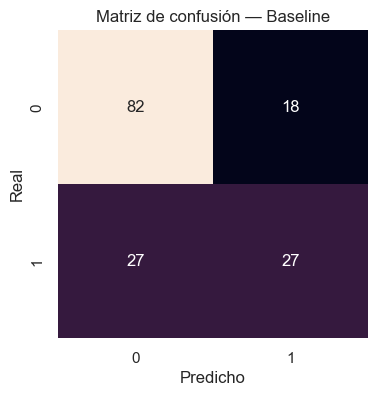

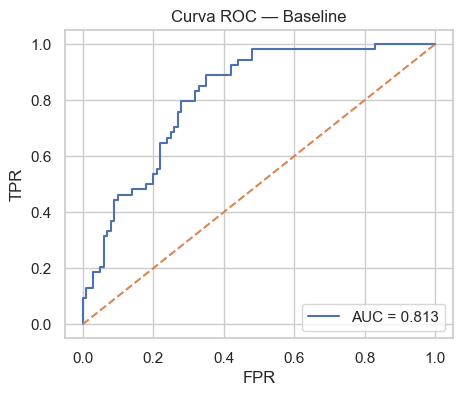

In [13]:

numeric_features = list(X_train.columns)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocess = ColumnTransformer(
    transformers=[('num', numeric_transformer, numeric_features)],
    remainder='drop'
)

baseline_clf = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

baseline_clf.fit(X_train, y_train)
y_pred_base = baseline_clf.predict(X_test)
y_proba_base = baseline_clf.predict_proba(X_test)[:,1]

base_acc  = accuracy_score(y_test, y_pred_base)
base_prec = precision_score(y_test, y_pred_base, zero_division=0)
base_rec  = recall_score(y_test, y_pred_base, zero_division=0)
base_f1   = f1_score(y_test, y_pred_base, zero_division=0)

print(f"Baseline (LogReg) -> acc={base_acc:.3f}  prec={base_prec:.3f}  rec={base_rec:.3f}  f1={base_f1:.3f}")
print("\nClassification Report (Baseline):\n")
print(classification_report(y_test, y_pred_base, digits=3))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_base)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.title('Matriz de confusión — Baseline')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

# ROC / AUC
fpr, tpr, _ = roc_curve(y_test, y_proba_base)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curva ROC — Baseline')
plt.legend(loc='lower right')
plt.show()



## 6. Entrenamiento con AutoGluon (AutoML)
Se configura `preset="best_quality"` y métrica `accuracy`. También se limita el tiempo de entrenamiento con `time_limit` para evitar ejecuciones largas.


In [16]:


from autogluon.tabular import TabularDataset, TabularPredictor

LABEL = 'Outcome'
TIME_LIMIT = 300  # segundos (ajustar si se desea entrenar por más tiempo)

train_ag = pd.concat([X_train, y_train], axis=1)
test_ag  = pd.concat([X_test, y_test], axis=1)

predictor = TabularPredictor(
    label=LABEL,
    eval_metric='accuracy',
    problem_type='binary',
).fit(
    train_data=train_ag,
    presets='best_quality',
    time_limit=TIME_LIMIT,
    verbosity=2
)

leader = predictor.leaderboard(test_ag, silent=True)
display(leader)
best_model = leader.iloc[0]['model']
print("Mejor modelo según accuracy en test:", best_model)


c:\Users\DELL I7\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No path specified. Models will be saved in: "AutogluonModels\ag-20250929_060328"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.0
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          8
Memory Avail:       1.99 GB / 11.74 GB (17.0%)
Disk Space Avail:   86.35 GB / 458.48 GB (18.8%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,RandomForestEntr_BAG_L1,0.759740,0.754072,accuracy,0.203727,0.128464,0.875437,0.203727,0.128464,0.875437,1,True,6
1,LightGBM_BAG_L1,0.759740,0.788274,accuracy,0.353818,0.016161,2.525942,0.353818,0.016161,2.525942,1,True,4
2,LightGBMXT_BAG_L2,0.759740,0.820847,accuracy,4.892851,0.972518,45.089398,0.276999,0.018577,2.884374,2,True,15
3,WeightedEnsemble_L3,0.759740,0.820847,accuracy,4.919328,0.974940,45.434788,0.026477,0.002422,0.345390,3,True,23
4,RandomForestGini_BAG_L1,0.753247,0.750814,accuracy,0.192346,0.133852,1.131449,0.192346,0.133852,1.131449,1,True,5
5,XGBoost_BAG_L1,0.753247,0.780130,accuracy,0.735818,0.064785,3.632076,0.735818,0.064785,3.632076,1,True,11
6,ExtraTreesGini_BAG_L1,0.746753,0.755700,accuracy,0.203670,0.115305,0.921168,0.203670,0.115305,0.921168,1,True,8
7,LightGBMXT_BAG_L1,0.746753,0.801303,accuracy,0.561305,0.021777,1.887021,0.561305,0.021777,1.887021,1,True,3
8,ExtraTreesEntr_BAG_L2,0.746753,0.785016,accuracy,4.819075,1.171687,43.143727,0.203223,0.217746,0.938703,2,True,21
9,ExtraTreesGini_BAG_L2,0.746753,0.771987,accuracy,4.832169,1.149857,43.100068,0.216317,0.195915,0.895044,2,True,20


Mejor modelo según accuracy en test: RandomForestEntr_BAG_L1



## 7. Evaluación del mejor modelo
Incluye matriz de confusión, métricas (accuracy, precision, recall, F1), y curva ROC/AUC.


c:\Users\DELL I7\AppData\Local\Programs\Python\Python310\lib\site-packages\fastai\learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")
c:\Users\DELL I7\AppData\Local\Programs\Python\Python310\lib\site-packages\fastai\learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which ca

AutoGluon (best) -> acc=0.760  prec=0.689  rec=0.574  f1=0.626

Classification Report (AutoGluon best):

              precision    recall  f1-score   support

           0      0.789     0.860     0.823       100
           1      0.689     0.574     0.626        54

    accuracy                          0.760       154
   macro avg      0.739     0.717     0.725       154
weighted avg      0.754     0.760     0.754       154



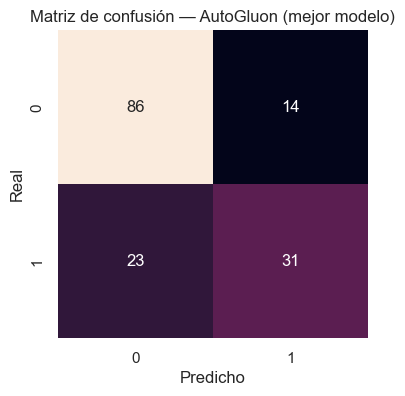

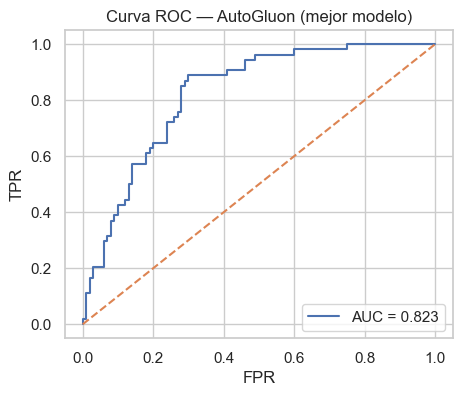

In [18]:
import numpy as np
import pandas as pd

# Predicción y probabilidades
y_pred_ag = predictor.predict(X_test)

# Fuerza retorno como pandas si es posible (más estable para binario)
try:
    proba_obj = predictor.predict_proba(X_test, as_pandas=True)
except TypeError:
    # Para versiones que no soportan as_pandas
    proba_obj = predictor.predict_proba(X_test)

# Detecta clase positiva
pos_label = 1
try:
    # Algunas versiones exponen positive_class
    if hasattr(predictor, "positive_class") and predictor.positive_class is not None:
        pos_label = predictor.positive_class
    elif hasattr(predictor, "class_labels") and predictor.class_labels is not None:
        # fallback: segunda etiqueta suele ser la positiva (binario)
        if len(predictor.class_labels) == 2:
            pos_label = predictor.class_labels[1]
except Exception:
    pass

# Normaliza y extrae prob. de clase positiva (y_proba_ag) de forma segura
if isinstance(proba_obj, pd.Series):
    # Series 1D: úsala tal cual
    y_proba_ag = proba_obj.to_numpy()
elif isinstance(proba_obj, pd.DataFrame):
    # DataFrame: intenta por etiqueta de columna de la clase positiva
    cols = list(proba_obj.columns)
    # Si la etiqueta existe literal, úsala; si no, toma la última columna
    col_to_use = pos_label if pos_label in proba_obj.columns else cols[-1]
    y_proba_ag = proba_obj[col_to_use].to_numpy()
else:
    # Numpy-like: maneja 1D/2D
    arr = np.asarray(proba_obj)
    if arr.ndim == 1:
        y_proba_ag = arr
    else:
        # Si hay 2+ columnas, toma la segunda como positiva por convención
        y_proba_ag = arr[:, 1] if arr.shape[1] > 1 else arr.ravel()

# ---- métricas y gráficos idénticos a tu celda ----
ag_acc  = accuracy_score(y_test, y_pred_ag)
ag_prec = precision_score(y_test, y_pred_ag, zero_division=0)
ag_rec  = recall_score(y_test, y_pred_ag, zero_division=0)
ag_f1   = f1_score(y_test, y_pred_ag, zero_division=0)

print(f"AutoGluon (best) -> acc={ag_acc:.3f}  prec={ag_prec:.3f}  rec={ag_rec:.3f}  f1={ag_f1:.3f}")
print("\nClassification Report (AutoGluon best):\n")
print(classification_report(y_test, y_pred_ag, digits=3))

cm_ag = confusion_matrix(y_test, y_pred_ag)
plt.figure(figsize=(4,4))
sns.heatmap(cm_ag, annot=True, fmt='d', cbar=False)
plt.title('Matriz de confusión — AutoGluon (mejor modelo)')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

fpr_ag, tpr_ag, _ = roc_curve(y_test, y_proba_ag)
roc_auc_ag = auc(fpr_ag, tpr_ag)

plt.figure(figsize=(5,4))
plt.plot(fpr_ag, tpr_ag, label=f'AUC = {roc_auc_ag:.3f}')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curva ROC — AutoGluon (mejor modelo)')
plt.legend(loc='lower right')
plt.show()



## 8. Importancia de características
AutoGluon permite obtener la importancia de características con `predictor.feature_importance`.


Computing feature importance via permutation shuffling for 8 features using 154 rows with 5 shuffle sets...
c:\Users\DELL I7\AppData\Local\Programs\Python\Python310\lib\site-packages\fastai\learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")
c:\Users\DELL I7\AppData\Local\Programs\Python\Python310\lib\site-packages\fastai\learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer stat

,importance,stddev,p_value,n,p99_high,p99_low
Glucose,0.119481,0.044184,0.001887,5,0.210457,0.028504
Age,0.038961,0.014520,0.001941,5,0.068858,0.009064
BloodPressure,0.035065,0.011796,0.001330,5,0.059353,0.010777
Pregnancies,0.029870,0.024555,0.026492,5,0.080430,-0.020690
BMI,0.024675,0.019696,0.024371,5,0.065229,-0.015879
DiabetesPedigreeFunction,0.024675,0.016169,0.013483,5,0.057967,-0.008616
SkinThickness,0.018182,0.018019,0.043518,5,0.055283,-0.018919
Insulin,0.016883,0.012658,0.020321,5,0.042946,-0.009180


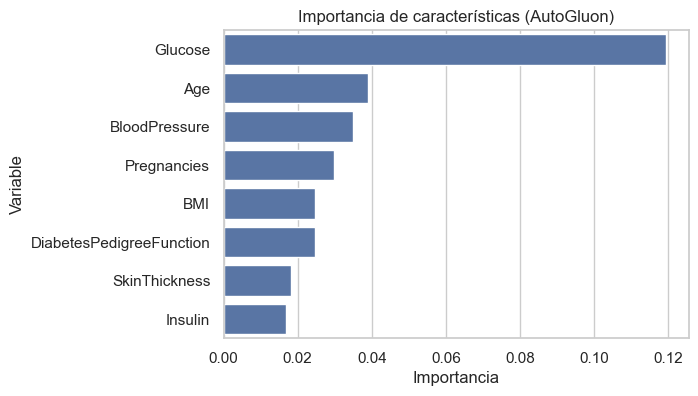

In [19]:

fi = predictor.feature_importance(data=test_ag)
display(fi)

plt.figure(figsize=(6,4))
sns.barplot(x=fi['importance'], y=fi.index, orient='h')
plt.title('Importancia de características (AutoGluon)')
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.show()



## 9. Comparación Baseline vs AutoGluon
Tabla rápida de comparación entre el modelo base y el mejor modelo de AutoGluon.


In [20]:

comp = pd.DataFrame({
    'modelo': ['Baseline_LogisticRegression', 'AutoGluon_best'],
    'accuracy': [base_acc, ag_acc],
    'precision': [base_prec, ag_prec],
    'recall': [base_rec, ag_rec],
    'f1': [base_f1, ag_f1],
}).sort_values('accuracy', ascending=False)
display(comp)


,modelo,accuracy,precision,recall,f1
1,AutoGluon_best,0.759740,0.688889,0.574074,0.626263
0,Baseline_LogisticRegression,0.707792,0.600000,0.500000,0.545455



## 10. Reflexión crítica (AutoML en salud)
**Ventajas de AutoGluon/AutoML:**
- Acelera la experimentación con múltiples modelos y ensamblados.
- Automatiza *tuning* y selección de modelos, logrando resultados competitivos.
- Facilita *baseline* fuertes y reproducibles con poco código.

**Desventajas / Precauciones:**
- **Interpretabilidad**: los mejores modelos pueden ser ensamblados complejos (difíciles de explicar).
- **Riesgo de sobreajuste** si no se valida correctamente (p. ej., *time leakage*, *data leakage*).
- **Costos computacionales**: `best_quality` puede ser pesado en tiempo y recursos.
- Dependencia de *defaults*: es fundamental revisar *reports*, *leaderboard* y métricas más allá de `accuracy`.

**Métricas relevantes para este problema:**
- Además de `accuracy`, es clave monitorear **recall** (sensibilidad) para reducir falsos negativos.
- **Precision** y **F1** equilibran la evaluación; **AUC-ROC** resume desempeño en umbrales variados.

**Aplicación en salud (precauciones):**
- Validación rigurosa, potencialmente con **validación cruzada** y separación temporal si aplica.
- **Explicabilidad**: considerar técnicas de interpretación (SHAP, *permutation importance*).
- **Ética y sesgos**: evaluar sesgos; evitar decisiones clínicas sin supervisión humana.
- Integración con el flujo clínico: los modelos deben apoyar, **no reemplazar**, el juicio médico.

**Comparación con un modelo manual:**
- Manual (p. ej., Regresión Logística) ofrece mayor interpretabilidad y control fino.
- AutoGluon logra mejor desempeño con menos esfuerzo pero puede ser menos transparente.
- En práctica, combinar ambos enfoques: **baseline interpretable** + **AutoML** para maximizar rendimiento y comprensión.
